In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from datasets import load_dataset

In [ ]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/thesis/quixo_one_move_with_prompts_train')
test_df = pd.read_csv('/content/drive/MyDrive/thesis/quixo_one_move_with_prompts_test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
from datasets import Dataset
import pandas as pd

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
from transformers import AutoTokenizer

def preprocess_function(examples):
    model_inputs = tokenizer(examples["prompt"], max_length=350, truncation=True, padding="max_length",)
    labels = tokenizer(examples["answer"], max_length=128, truncation=True, padding="max_length",)
    model_inputs["labels"] = labels["input_ids"]
    return {k: torch.tensor(v).to(device) for k, v in model_inputs.items()}

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [ ]:
import peft
from peft import LoraConfig, get_peft_model, PromptTuningConfig

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
import numpy as np
hist = []
prompts_length = []
all_completions = []

In [ ]:
import re

def extract_answer_text(text):
    pattern = r'<answer>(.*?)</answer>'
    matches = re.findall(pattern, re.sub(r"\s+", "", text))
    if matches:
        return matches[0]
    else:
        return ""

def reward_func(completions, answer, **kwargs):
    # print(completions)
    global hist
    global prompts_length
    predicted = [extract_answer_text(t) for t in completions]
    all_completions.append(completions)

    rewards = [1.0 if c == re.sub(r"\s+", "", gt) else 0.0 for c, gt in zip(predicted, answer)]
    print(predicted, answer, np.mean(rewards))
    hist.append(np.mean(rewards))
    prompts_length.append(np.mean([len(t) for t in completions]))

    return rewards

In [ ]:
from datasets import load_dataset
from trl import GRPOTrainer, GRPOConfig

dataset = tokenized_train_dataset


trainer = GRPOTrainer(
    args=GRPOConfig(
        report_to='none',
    ),
    model=model,
    reward_funcs=reward_func,
    train_dataset=dataset,
    # peft_config=lora_config,
)

trainer.train()

In [ ]:
def exponential_smoothing(array, alpha):
    smoothed = [array[0]]  # First value is same as original
    for i in range(1, len(array)):
        smoothed.append(alpha * array[i] + (1 - alpha) * smoothed[i-1])
    return smoothed

In [ ]:
import seaborn as sns

In [ ]:
np.mean(hist[-10:])

np.float64(0.75)

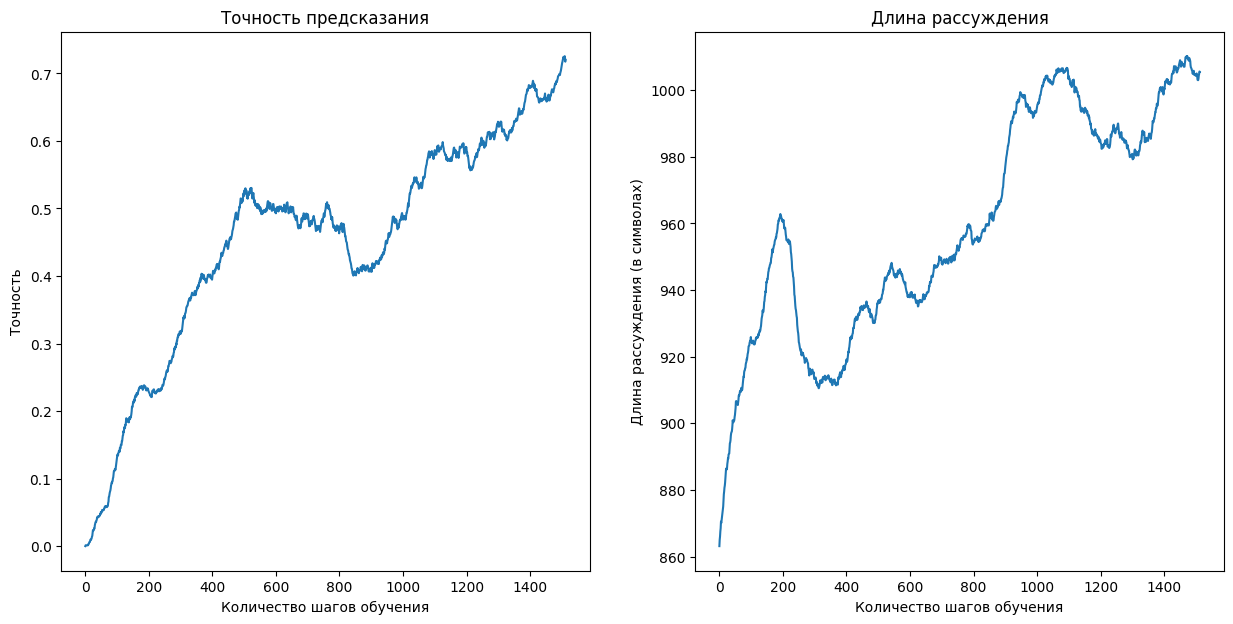

In [ ]:
plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Точность предсказания")
plt.ylabel("Точность")
plt.xlabel("Количество шагов обучения")
sns.lineplot(exponential_smoothing(hist, .01))

plt.subplot(1, 2, 2)
plt.title("Длина рассуждения")
plt.ylabel("Длина рассуждения (в символах)")
plt.xlabel("Количество шагов обучения")
sns.lineplot(exponential_smoothing(prompts_length, .01))

plt.show()